# CARGA DEL DATASET PARA LA MODELIZACIÓN

In [67]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support
)
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
import torch
from datasets import Dataset
import shap
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
import optuna


torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True

In [83]:
df = pd.read_csv("reddit_depression_dataset_clean.csv")

df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["label"]
)

# Luego sacas las columnas que necesitas de cada pedazo
# Para el modelo clásico
X_train_lr = df_train["body"]
X_test_lr  = df_test["body"]

# Para BERT (Texto crudo)
X_train_bert = df_train["body_raw"]
X_test_bert  = df_test["body_raw"]

# Etiquetas
y_train = df_train["label"].astype(int)
y_test  = df_test["label"].astype(int)

# 4. Mostrar tamaños para verificar
print("Tamaño total:        ", len(df))
print("Tamaño train LR:    ", len(X_train_lr))
print("Tamaño test LR:     ", len(X_test_lr))
print("Tamaño train BERT:  ", len(X_train_bert))
print("Tamaño test BERT:   ", len(X_test_bert))

Tamaño total:         78206
Tamaño train LR:     62564
Tamaño test LR:      15642
Tamaño train BERT:   62564
Tamaño test BERT:    15642


# MODELIZACIÓN

## 1. Regresión Logística con TF-IDF

In [70]:
## Vectorización TF-IDF
tfidf = TfidfVectorizer(
    max_features=20000,       
    ngram_range=(1, 2),       
    min_df=5,                 
    max_df=0.95,              
    stop_words='english'      
)

X_train_tfidf = tfidf.fit_transform(X_train_lr)
X_test_tfidf = tfidf.transform(X_test_lr)

print("Shape TF-IDF train:", X_train_tfidf.shape)
print("Shape TF-IDF test: ", X_test_tfidf.shape)

Shape TF-IDF train: (62564, 20000)
Shape TF-IDF test:  (15642, 20000)


In [71]:
model = LogisticRegression(
    max_iter=300,
    solver='lbfgs',
    n_jobs=-1
)

model.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,300
,multi_class,'deprecated'


In [72]:
y_pred = model.predict(X_test_tfidf)

accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)

print("\n=== METRICS ===")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)



=== METRICS ===
Accuracy : 0.9130545965989004
Precision: 0.9229405507623213
Recall   : 0.9168721380767876
F1-score : 0.9198963364353869



=== CONFUSION MATRIX ===


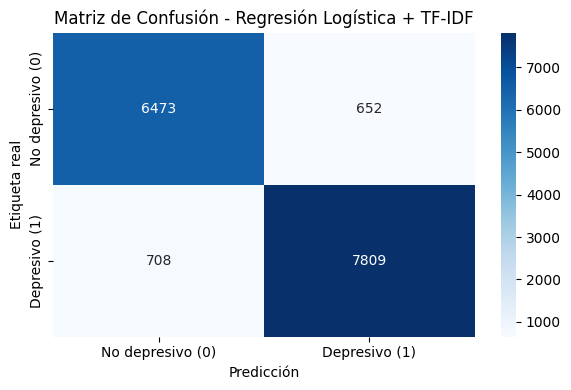

In [73]:
print("\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No depresivo (0)", "Depresivo (1)"],
    yticklabels=["No depresivo (0)", "Depresivo (1)"]
)

plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión - Regresión Logística + TF-IDF")
plt.tight_layout()
plt.show()

In [74]:
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred))


=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90      7125
         1.0       0.92      0.92      0.92      8517

    accuracy                           0.91     15642
   macro avg       0.91      0.91      0.91     15642
weighted avg       0.91      0.91      0.91     15642



In [75]:
# Análisis de coeficientes e interpretabilidad
feature_names = tfidf.get_feature_names_out()
coefs = model.coef_[0]

# Top 20 palabras que más predicen clase depresiva (1)
top_pos_indices = np.argsort(coefs)[-20:]
print("Palabras predictoras de depresión:")
for idx in reversed(top_pos_indices):
    print(feature_names[idx], coefs[idx])

# Top 20 palabras que predicen clase no depresiva (0)
top_neg_indices = np.argsort(coefs)[:20]
print("\nPalabras predictoras de NO depresión:")
for idx in top_neg_indices:
    print(feature_names[idx], coefs[idx])

Palabras predictoras de depresión:
depress 14.528246609305096
suicid 10.031794485254721
kill 7.953374961743217
life 7.818547562849883
anymor 6.933081545938458
feel 6.626193323147637
wish 5.800389143056255
alon 5.774174997649309
want die 4.966472752788469
tire 4.417036785833766
therapist 4.379111007136413
therapi 4.369868916735323
antidepress 4.310262546110786
noth 4.259365576485108
worthless 4.242263675348919
pain 4.210979942872769
end 4.060487086785352
aliv 4.056041310801897
everyth 4.036018927367483
die 3.927135451778033

Palabras predictoras de NO depresión:
teenag -6.320698762723957
crush -5.574931149580641
rteenag -4.659704066943952
minecraft -4.562056047746485
rant -4.454728630360731
teen -4.385284843084229
yall -4.0330700658992455
meme -4.017629126186518
guy -3.9830390034006284
school -3.9451642520266104
kinda -3.91421950990067
girl -3.7360604210471355
horni -3.6478433774352705
ass -3.3366255382745487
teacher -3.2915954152212166
karma -3.2772712496509264
discuss -3.2004468521266

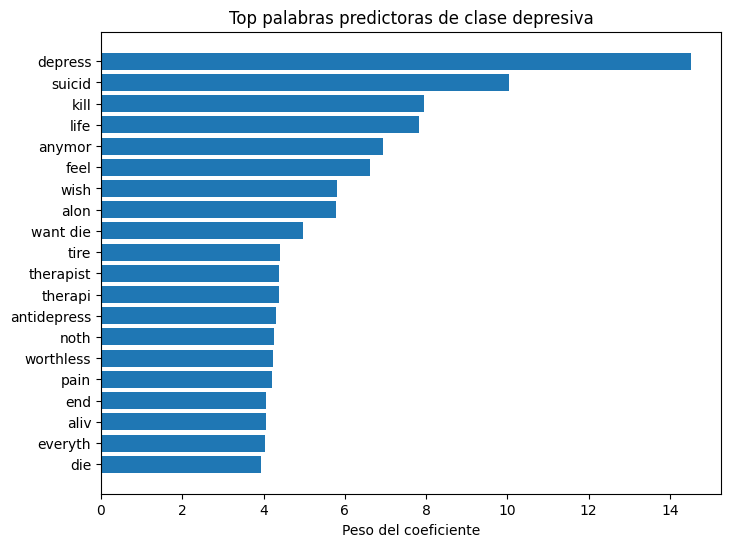

In [76]:
top_n = 20
indices = np.argsort(coefs)[-top_n:]

plt.figure(figsize=(8,6))
plt.barh([feature_names[i] for i in indices], coefs[indices])
plt.xlabel("Peso del coeficiente")
plt.title("Top palabras predictoras de clase depresiva")
plt.show()

## 2. Clasificación basada en BERT

In [84]:
train_ds = Dataset.from_dict({"text": X_train_bert.tolist(), "label": y_train.tolist()})
test_ds  = Dataset.from_dict({"text": X_test_bert.tolist(), "label": y_test.tolist()})

train_ds = train_ds.map(lambda x: {"label": int(x["label"])})
test_ds = test_ds.map(lambda x: {"label": int(x["label"])})

Map: 100%|██████████| 15642/15642 [00:00<00:00, 91777.46 examples/s]


In [85]:
## tokenización
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )
train_ds = train_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

train_ds = train_ds.remove_columns(["text"])
test_ds  = test_ds.remove_columns(["text"])

train_ds = train_ds.with_format("torch")
test_ds  = test_ds.with_format("torch")

Map: 100%|██████████| 15642/15642 [00:00<00:00, 19252.72 examples/s]


In [86]:
### modelo
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [87]:
# Metricas para el modelo de transformers
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary"
    )
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [88]:
# Entrenamiento del modelo

training_args = TrainingArguments(
    output_dir="./distilbert_output",
    eval_strategy="epoch",
    save_strategy="epoch",           
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,     
    fp16=True,
    optim="adamw_torch",
    dataloader_num_workers=0,
    dataloader_pin_memory=False
)

trainer = Trainer(
    model=model.to("cuda"),          
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_26412\1299772822.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.179200,0.203051,0.931083,0.905837,0.974756,0.939034
2,0.117500,0.179685,0.940673,0.946780,0.944112,0.945444
3,0.038100,0.239626,0.939074,0.931834,0.958201,0.944834


TrainOutput(global_step=5868, training_loss=0.12246886999857369, metrics={'train_runtime': 278.5735, 'train_samples_per_second': 673.761, 'train_steps_per_second': 21.064, 'total_flos': 6215767747135488.0, 'train_loss': 0.12246886999857369, 'epoch': 3.0})

In [89]:
metrics = trainer.evaluate()
print("\n=== DISTILBERT METRICS ===")
print(metrics)


=== DISTILBERT METRICS ===
{'eval_loss': 0.17968523502349854, 'eval_accuracy': 0.940672548267485, 'eval_precision': 0.9467797009301778, 'eval_recall': 0.9441117764471058, 'eval_f1': 0.9454438565549677, 'eval_runtime': 5.8342, 'eval_samples_per_second': 2681.102, 'eval_steps_per_second': 83.817, 'epoch': 3.0}


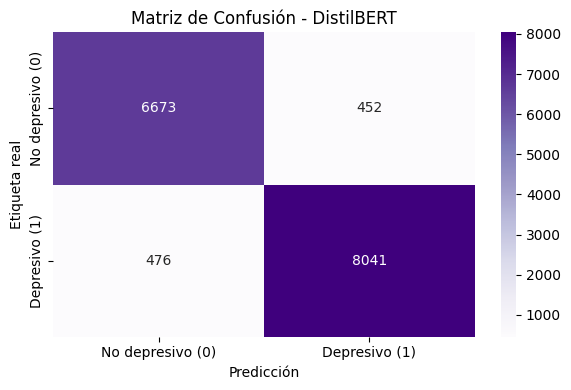

In [90]:
predictions = trainer.predict(test_ds)
y_pred = predictions.predictions.argmax(-1)
y_true = predictions.label_ids

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Purples",
    xticklabels=["No depresivo (0)", "Depresivo (1)"],
    yticklabels=["No depresivo (0)", "Depresivo (1)"]
)

plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión - DistilBERT")
plt.tight_layout()
plt.show()

In [92]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained(
    "./distilbert_output/checkpoint-3912"
    
).to("cuda")
model.eval()

def predict_proba(texts):
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()
    
    # El resto sigue igual
    tokens = tokenizer(
        texts, 
        truncation=True, 
        padding=True, 
        max_length=128, 
        return_tensors="pt"
    ).to("cuda")
    
    with torch.no_grad():
        outputs = model(**tokens)
        probs = outputs.logits.softmax(dim=1)
        
    return probs.cpu().numpy()

explainer = shap.Explainer(
    predict_proba,
    tokenizer,
    output_names=["no_depressivo", "depressivo"]
)

sample_texts =  X_test_bert.sample(400, random_state=42).tolist()

shap_values = explainer(sample_texts)


PartitionExplainer explainer:  43%|████▎     | 172/400 [01:05<01:44,  2.18it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors
PartitionExplainer explainer: 401it [02:33,  2.41it/s]                         


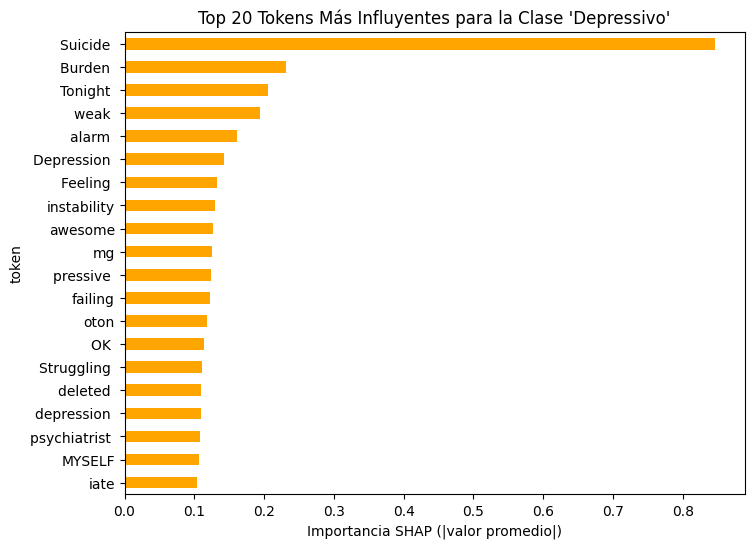

In [93]:
records = []
for ex in shap_values:
    tokens = ex.data
    values = ex.values  

    for tok, val in zip(tokens, values):
        records.append({
            "token": tok,
            "value_depressivo": val[1]
        })

df_dbert = pd.DataFrame(records)
df_dbert = df_dbert[df_dbert["token"].str.strip() != ""]

global_importance = (
    df_dbert.groupby("token")["value_depressivo"]
      .apply(lambda x: np.mean(np.abs(x)))
      .sort_values(ascending=False)
)

top_n = 20
plt.figure(figsize=(8, 6))
global_importance.head(top_n).plot(kind="barh", color="orange")
plt.title("Top 20 Tokens Más Influyentes para la Clase 'Depressivo'")
plt.gca().invert_yaxis()
plt.xlabel("Importancia SHAP (|valor promedio|)")
plt.show()

# Tuning de Hiperparámetros

## 1. Regresión Logística con TF-IDF

In [94]:
lr = LogisticRegression(
    solver="lbfgs",
    max_iter=300,
    n_jobs=-1
)

param_dist = {
    "C": loguniform(1e-3, 1e2),      
    "penalty": ["l2"],              
    "max_iter": [200, 300, 500],
}


In [95]:
random_search = RandomizedSearchCV(
    lr,
    param_distributions=param_dist,
    n_iter=10,
    scoring="f1",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train_tfidf, y_train)

print("\n=== MEJORES HIPERPARÁMETROS ===")
print(random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits

=== MEJORES HIPERPARÁMETROS ===
{'C': np.float64(1.2229467525390603), 'max_iter': 300, 'penalty': 'l2'}


In [96]:
best_lr = random_search.best_estimator_

y_pred = best_lr.predict(X_test_tfidf)

accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)

print("\n=== METRICS (Modelo Tuned) ===")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)



=== METRICS (Modelo Tuned) ===
Accuracy : 0.913438179260964
Precision: 0.9238963190910167
Recall   : 0.9165199013737232
F1-score : 0.9201933278321348


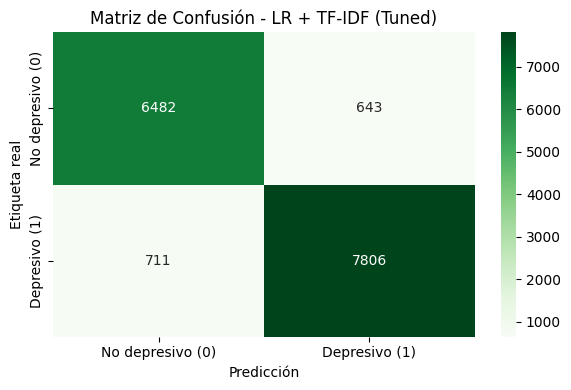

In [97]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["No depresivo (0)", "Depresivo (1)"],
    yticklabels=["No depresivo (0)", "Depresivo (1)"]
)

plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión - LR + TF-IDF (Tuned)")
plt.tight_layout()
plt.show()

In [98]:
# Análisis de coeficientes e interpretabilidad
feature_names = tfidf.get_feature_names_out()
coefs = best_lr.coef_[0]

# Top 20 palabras que más predicen clase depresiva (1)
top_pos_indices = np.argsort(coefs)[-20:]
print("Palabras predictoras de depresión:")
for idx in reversed(top_pos_indices):
    print(feature_names[idx], coefs[idx])

# Top 20 palabras que predicen clase no depresiva (0)
top_neg_indices = np.argsort(coefs)[:20]
print("\nPalabras predictoras de NO depresión:")
for idx in top_neg_indices:
    print(feature_names[idx], coefs[idx])

Palabras predictoras de depresión:
depress 15.300954862902222
suicid 10.424595601981673
kill 8.433001835962283
life 7.891929600242961
anymor 7.096309756864429
feel 6.535359747451652
wish 6.10831415154498
alon 5.9295133414177075
want die 5.328553605100174
tire 4.652352810250199
antidepress 4.6419577669965735
worthless 4.477053321467649
noth 4.467128972506413
rdepress 4.464326227135484
therapi 4.458404498961455
pain 4.393165900709501
therapist 4.389352856510244
end 4.25070776349071
everyth 4.123870701129014
live 4.039728924729136

Palabras predictoras de NO depresión:
teenag -6.517041603137848
crush -5.610379820222318
rteenag -5.038830043943035
minecraft -4.86002944457907
rant -4.7290526151837655
teen -4.45417450686969
school -4.125967090487488
meme -4.090373119978986
guy -4.089806287006806
yall -4.066728467313445
girl -3.9468280875671304
kinda -3.8878863850451166
horni -3.6934583216834
karma -3.4592908791455943
discuss -3.419577831734813
boi -3.4116530425974445
ass -3.40264313667124
tea

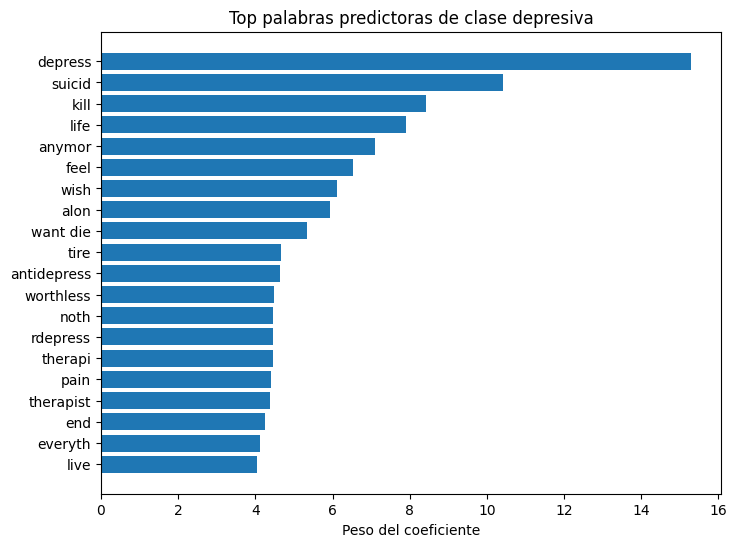

In [99]:
top_n = 20
indices = np.argsort(coefs)[-top_n:]

plt.figure(figsize=(8,6))
plt.barh([feature_names[i] for i in indices], coefs[indices])
plt.xlabel("Peso del coeficiente")
plt.title("Top palabras predictoras de clase depresiva")
plt.show()

## 2. Clasificación basada en BERT

In [ ]:
def objective(trial):

    # Hiperparámetros sugeridos
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 5e-5, log=True)
    batch_size    = trial.suggest_categorical("batch_size", [16, 32])
    weight_decay  = trial.suggest_float("weight_decay", 0.0, 0.1)
    num_epochs    = trial.suggest_int("num_epochs", 2, 4)
    warmup_ratio = trial.suggest_float("warmup_ratio", 0.0, 0.1)

    # Crear modelo fresco
    model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=2
    ).to("cuda")

    # Training arguments coherentes con tu notebook
    training_args = TrainingArguments(
        output_dir=f"./optuna_trial_{trial.number}",
        eval_strategy="epoch",
        save_strategy="no",
        
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        report_to="none",                
        disable_tqdm=True,  
        fp16=True,
        logging_steps=50,
        optim="adamw_torch",
        dataloader_num_workers=0,
        dataloader_pin_memory=False
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )
    trainer.train()
    
    # Entrenamiento + evaluación
    eval_results = trainer.evaluate()

    # Optuna maximiza F1
    return eval_results["eval_f1"]

# Ejecutar optimización bayesiana
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

[I 2025-12-02 22:23:04,297] A new study created in memory with name: no-name-733740f2-2677-4e02-96cd-87bd4717f05f
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Usuario\AppData\Local\Temp\ipykernel_26412\3682238805.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.4791, 'grad_norm': 5.7292656898498535, 'learning_rate': 3.8658478711264905e-05, 'epoch': 0.012784454103809767}
{'loss': 0.2762, 'grad_norm': 3.8045637607574463, 'learning_rate': 3.8409807164170705e-05, 'epoch': 0.025568908207619534}
{'loss': 0.2877, 'grad_norm': 3.6985905170440674, 'learning_rate': 3.8166109048018384e-05, 'epoch': 0.0383533623114293}
{'loss': 0.2371, 'grad_norm': 2.8114874362945557, 'learning_rate': 3.791743750092418e-05, 'epoch': 0.05113781641523907}
{'loss': 0.2827, 'grad_norm': 4.093538761138916, 'learning_rate': 3.766876595382998e-05, 'epoch': 0.06392227051904883}
{'loss': 0.2781, 'grad_norm': 5.445436000823975, 'learning_rate': 3.742009440673577e-05, 'epoch': 0.0767067246228586}
{'loss': 0.2187, 'grad_norm': 3.1141223907470703, 'learning_rate': 3.717142285964157e-05, 'epoch': 0.08949117872666837}
{'loss': 0.3114, 'grad_norm': 4.365882873535156, 'learning_rate': 3.692275131254737e-05, 'epoch': 0.10227563283047814}
{'loss': 0.2024, 'grad_norm': 8.07956123

[I 2025-12-02 22:27:22,151] Trial 0 finished with value: 0.9477594613420014 and parameters: {'learning_rate': 3.882260193234708e-05, 'batch_size': 16, 'weight_decay': 0.019118510003053257, 'num_epochs': 2, 'warmup_ratio': 0.0020015419454097907}. Best is trial 0 with value: 0.9477594613420014.


{'eval_loss': 0.19884419441223145, 'eval_accuracy': 0.9424626006904487, 'eval_precision': 0.9372058317070371, 'eval_recall': 0.9585534812727486, 'eval_f1': 0.9477594613420014, 'eval_runtime': 6.4423, 'eval_samples_per_second': 2428.0, 'eval_steps_per_second': 151.808, 'epoch': 2.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Usuario\AppData\Local\Temp\ipykernel_26412\3682238805.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.6785, 'grad_norm': 1.2635468244552612, 'learning_rate': 5.515961435104977e-06, 'epoch': 0.012784454103809767}
{'loss': 0.4991, 'grad_norm': 3.3173296451568604, 'learning_rate': 1.114449351174271e-05, 'epoch': 0.025568908207619534}
{'loss': 0.3266, 'grad_norm': 3.641148328781128, 'learning_rate': 1.677302558838044e-05, 'epoch': 0.0383533623114293}
{'loss': 0.2666, 'grad_norm': 3.164024829864502, 'learning_rate': 2.228898702348542e-05, 'epoch': 0.05113781641523907}
{'loss': 0.2924, 'grad_norm': 5.290125370025635, 'learning_rate': 2.791751910012315e-05, 'epoch': 0.06392227051904883}
{'loss': 0.2794, 'grad_norm': 4.099650859832764, 'learning_rate': 3.354605117676088e-05, 'epoch': 0.0767067246228586}
{'loss': 0.2768, 'grad_norm': 6.071284770965576, 'learning_rate': 3.9174583253398617e-05, 'epoch': 0.08949117872666837}
{'loss': 0.2898, 'grad_norm': 4.645443439483643, 'learning_rate': 4.480311533003635e-05, 'epoch': 0.10227563283047814}
{'loss': 0.2338, 'grad_norm': 4.2744469642639

[I 2025-12-02 22:31:39,381] Trial 1 finished with value: 0.9461815645704986 and parameters: {'learning_rate': 4.502825661310186e-05, 'batch_size': 16, 'weight_decay': 0.03626709529502566, 'num_epochs': 2, 'warmup_ratio': 0.05104600640669835}. Best is trial 0 with value: 0.9477594613420014.


{'eval_loss': 0.1958610564470291, 'eval_accuracy': 0.9408004091548395, 'eval_precision': 0.9368166647485326, 'eval_recall': 0.955735587648233, 'eval_f1': 0.9461815645704986, 'eval_runtime': 6.4479, 'eval_samples_per_second': 2425.899, 'eval_steps_per_second': 151.677, 'epoch': 2.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Usuario\AppData\Local\Temp\ipykernel_26412\3682238805.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.6882, 'grad_norm': 1.0039091110229492, 'learning_rate': 1.8298943970362062e-06, 'epoch': 0.02556237218813906}
{'loss': 0.6238, 'grad_norm': 1.5804903507232666, 'learning_rate': 3.6971335776853965e-06, 'epoch': 0.05112474437627812}
{'loss': 0.4567, 'grad_norm': 2.0838029384613037, 'learning_rate': 5.564372758334587e-06, 'epoch': 0.07668711656441718}
{'loss': 0.3064, 'grad_norm': 3.0184571743011475, 'learning_rate': 7.431611938983777e-06, 'epoch': 0.10224948875255624}
{'loss': 0.2507, 'grad_norm': 3.0290215015411377, 'learning_rate': 9.298851119632966e-06, 'epoch': 0.1278118609406953}
{'loss': 0.2479, 'grad_norm': 4.673553466796875, 'learning_rate': 1.1166090300282157e-05, 'epoch': 0.15337423312883436}
{'loss': 0.2196, 'grad_norm': 2.9394030570983887, 'learning_rate': 1.3033329480931347e-05, 'epoch': 0.17893660531697342}
{'loss': 0.2306, 'grad_norm': 4.692562103271484, 'learning_rate': 1.3269950367591326e-05, 'epoch': 0.20449897750511248}
{'loss': 0.2259, 'grad_norm': 2.638222

[I 2025-12-02 22:36:28,346] Trial 2 finished with value: 0.9438695878374472 and parameters: {'learning_rate': 1.3369432533448201e-05, 'batch_size': 32, 'weight_decay': 0.0433118010379171, 'num_epochs': 3, 'warmup_ratio': 0.06085225024958673}. Best is trial 0 with value: 0.9477594613420014.


{'eval_loss': 0.19094817340373993, 'eval_accuracy': 0.937923539189362, 'eval_precision': 0.9296287861534958, 'eval_recall': 0.9585534812727486, 'eval_f1': 0.9438695878374472, 'eval_runtime': 5.8715, 'eval_samples_per_second': 2664.059, 'eval_steps_per_second': 83.284, 'epoch': 3.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Usuario\AppData\Local\Temp\ipykernel_26412\3682238805.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.627, 'grad_norm': 1.8418654203414917, 'learning_rate': 8.779991815796862e-06, 'epoch': 0.012784454103809767}
{'loss': 0.3646, 'grad_norm': 3.48974871635437, 'learning_rate': 8.724643867903636e-06, 'epoch': 0.025568908207619534}
{'loss': 0.3237, 'grad_norm': 3.3962690830230713, 'learning_rate': 8.668166370053405e-06, 'epoch': 0.0383533623114293}
{'loss': 0.2669, 'grad_norm': 1.8120197057724, 'learning_rate': 8.611688872203175e-06, 'epoch': 0.05113781641523907}
{'loss': 0.267, 'grad_norm': 4.569423198699951, 'learning_rate': 8.555211374352944e-06, 'epoch': 0.06392227051904883}
{'loss': 0.2725, 'grad_norm': 8.574850082397461, 'learning_rate': 8.498733876502713e-06, 'epoch': 0.0767067246228586}
{'loss': 0.2156, 'grad_norm': 2.736560821533203, 'learning_rate': 8.442256378652483e-06, 'epoch': 0.08949117872666837}
{'loss': 0.2874, 'grad_norm': 4.813608169555664, 'learning_rate': 8.385778880802252e-06, 'epoch': 0.10227563283047814}
{'loss': 0.217, 'grad_norm': 5.529397487640381, 'le

[I 2025-12-02 22:40:52,975] Trial 3 finished with value: 0.9429679810086272 and parameters: {'learning_rate': 8.81613741442101e-06, 'batch_size': 16, 'weight_decay': 0.06837387009152668, 'num_epochs': 2, 'warmup_ratio': 0.002051801325889424}. Best is trial 0 with value: 0.9477594613420014.


{'eval_loss': 0.1942981779575348, 'eval_accuracy': 0.93702851297788, 'eval_precision': 0.9302033356180032, 'eval_recall': 0.9560878243512974, 'eval_f1': 0.9429679810086272, 'eval_runtime': 6.6137, 'eval_samples_per_second': 2365.09, 'eval_steps_per_second': 147.875, 'epoch': 2.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Usuario\AppData\Local\Temp\ipykernel_26412\3682238805.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.6932, 'grad_norm': 0.9183472394943237, 'learning_rate': 5.649536048485366e-07, 'epoch': 0.02556237218813906}
{'loss': 0.6774, 'grad_norm': 0.9838224053382874, 'learning_rate': 1.1414368751021452e-06, 'epoch': 0.05112474437627812}
{'loss': 0.6388, 'grad_norm': 1.3575754165649414, 'learning_rate': 1.717920145355754e-06, 'epoch': 0.07668711656441718}
{'loss': 0.556, 'grad_norm': 1.4168237447738647, 'learning_rate': 2.294403415609363e-06, 'epoch': 0.10224948875255624}
{'loss': 0.4345, 'grad_norm': 1.600907802581787, 'learning_rate': 2.6807497297216783e-06, 'epoch': 0.1278118609406953}
{'loss': 0.3517, 'grad_norm': 2.5205588340759277, 'learning_rate': 2.6630550120337465e-06, 'epoch': 0.15337423312883436}
{'loss': 0.2913, 'grad_norm': 2.921792984008789, 'learning_rate': 2.6453602943458146e-06, 'epoch': 0.17893660531697342}
{'loss': 0.2785, 'grad_norm': 5.157702445983887, 'learning_rate': 2.6276655766578828e-06, 'epoch': 0.20449897750511248}
{'loss': 0.2658, 'grad_norm': 4.90571975

[I 2025-12-02 22:47:06,028] Trial 4 finished with value: 0.9395833333333333 and parameters: {'learning_rate': 2.6864120393818166e-06, 'batch_size': 32, 'weight_decay': 0.023248359231671224, 'num_epochs': 4, 'warmup_ratio': 0.02971599383389093}. Best is trial 0 with value: 0.9477594613420014.


{'eval_loss': 0.18590952455997467, 'eval_accuracy': 0.9332566168009206, 'eval_precision': 0.9263950701814447, 'eval_recall': 0.9531525184924269, 'eval_f1': 0.9395833333333333, 'eval_runtime': 5.0473, 'eval_samples_per_second': 3099.091, 'eval_steps_per_second': 96.884, 'epoch': 4.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Usuario\AppData\Local\Temp\ipykernel_26412\3682238805.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.68, 'grad_norm': 1.0674372911453247, 'learning_rate': 7.801692044188779e-06, 'epoch': 0.012784454103809767}
{'loss': 0.4483, 'grad_norm': 8.094221115112305, 'learning_rate': 1.5603384088377558e-05, 'epoch': 0.025568908207619534}
{'loss': 0.3089, 'grad_norm': 9.441045761108398, 'learning_rate': 2.356429433754978e-05, 'epoch': 0.0383533623114293}
{'loss': 0.2684, 'grad_norm': 1.6931068897247314, 'learning_rate': 2.9079718005925102e-05, 'epoch': 0.05113781641523907}
{'loss': 0.2875, 'grad_norm': 3.633291244506836, 'learning_rate': 2.888900631910765e-05, 'epoch': 0.06392227051904883}
{'loss': 0.2891, 'grad_norm': 4.3728461265563965, 'learning_rate': 2.8698294632290196e-05, 'epoch': 0.0767067246228586}
{'loss': 0.2417, 'grad_norm': 5.784646511077881, 'learning_rate': 2.8507582945472743e-05, 'epoch': 0.08949117872666837}
{'loss': 0.3143, 'grad_norm': 4.906983375549316, 'learning_rate': 2.831687125865529e-05, 'epoch': 0.10227563283047814}
{'loss': 0.2123, 'grad_norm': 4.89116287231

[I 2025-12-02 22:50:59,571] Trial 5 finished with value: 0.9460619417700963 and parameters: {'learning_rate': 2.9136931511970336e-05, 'batch_size': 16, 'weight_decay': 0.03528517943052441, 'num_epochs': 2, 'warmup_ratio': 0.0233693829698858}. Best is trial 0 with value: 0.9477594613420014.


{'eval_loss': 0.19766971468925476, 'eval_accuracy': 0.9405446873801304, 'eval_precision': 0.9347851002865329, 'eval_recall': 0.95761418339791, 'eval_f1': 0.9460619417700963, 'eval_runtime': 5.6839, 'eval_samples_per_second': 2752.001, 'eval_steps_per_second': 172.066, 'epoch': 2.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Usuario\AppData\Local\Temp\ipykernel_26412\3682238805.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.6114, 'grad_norm': 1.8136894702911377, 'learning_rate': 1.6043459357590467e-05, 'epoch': 0.02556237218813906}
{'loss': 0.3024, 'grad_norm': 2.3931024074554443, 'learning_rate': 3.241433625309094e-05, 'epoch': 0.05112474437627812}
{'loss': 0.2905, 'grad_norm': 6.112374305725098, 'learning_rate': 4.437548160517208e-05, 'epoch': 0.07668711656441718}
{'loss': 0.2564, 'grad_norm': 3.224766492843628, 'learning_rate': 4.3785852564444297e-05, 'epoch': 0.10224948875255624}
{'loss': 0.241, 'grad_norm': 3.777188301086426, 'learning_rate': 4.319622352371653e-05, 'epoch': 0.1278118609406953}
{'loss': 0.2358, 'grad_norm': 2.7046990394592285, 'learning_rate': 4.260659448298876e-05, 'epoch': 0.15337423312883436}
{'loss': 0.2194, 'grad_norm': 3.2644896507263184, 'learning_rate': 4.2016965442260986e-05, 'epoch': 0.17893660531697342}
{'loss': 0.2159, 'grad_norm': 3.7295637130737305, 'learning_rate': 4.142733640153322e-05, 'epoch': 0.20449897750511248}
{'loss': 0.2297, 'grad_norm': 2.3421018123

[I 2025-12-02 22:53:55,560] Trial 6 finished with value: 0.9467132053519488 and parameters: {'learning_rate': 4.4528785155761294e-05, 'batch_size': 32, 'weight_decay': 0.05206953330765105, 'num_epochs': 2, 'warmup_ratio': 0.0345914995849755}. Best is trial 0 with value: 0.9477594613420014.


{'eval_loss': 0.17607323825359344, 'eval_accuracy': 0.9414397135916123, 'eval_precision': 0.938199008416926, 'eval_recall': 0.9553833509451685, 'eval_f1': 0.9467132053519488, 'eval_runtime': 5.1162, 'eval_samples_per_second': 3057.326, 'eval_steps_per_second': 95.578, 'epoch': 2.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Usuario\AppData\Local\Temp\ipykernel_26412\3682238805.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.6942, 'grad_norm': 1.1157782077789307, 'learning_rate': 4.368045092745276e-07, 'epoch': 0.012784454103809767}
{'loss': 0.6865, 'grad_norm': 1.2889519929885864, 'learning_rate': 8.825233962893516e-07, 'epoch': 0.025568908207619534}
{'loss': 0.666, 'grad_norm': 1.341721534729004, 'learning_rate': 1.3282422833041757e-06, 'epoch': 0.0383533623114293}
{'loss': 0.6241, 'grad_norm': 1.707395076751709, 'learning_rate': 1.7739611703189999e-06, 'epoch': 0.05113781641523907}
{'loss': 0.5505, 'grad_norm': 2.355962038040161, 'learning_rate': 2.083243331496492e-06, 'epoch': 0.06392227051904883}
{'loss': 0.4638, 'grad_norm': 2.3479015827178955, 'learning_rate': 2.0741731323868763e-06, 'epoch': 0.0767067246228586}
{'loss': 0.383, 'grad_norm': 2.8430287837982178, 'learning_rate': 2.065102933277261e-06, 'epoch': 0.08949117872666837}
{'loss': 0.3492, 'grad_norm': 3.264185667037964, 'learning_rate': 2.0560327341676454e-06, 'epoch': 0.10227563283047814}
{'loss': 0.3013, 'grad_norm': 5.12890625, 

[I 2025-12-02 22:59:59,192] Trial 7 finished with value: 0.9375830013280213 and parameters: {'learning_rate': 2.0859643912293766e-06, 'batch_size': 16, 'weight_decay': 0.06834363041559591, 'num_epochs': 3, 'warmup_ratio': 0.01991179920587224}. Best is trial 0 with value: 0.9477594613420014.


{'eval_loss': 0.20785777270793915, 'eval_accuracy': 0.9308911903848612, 'eval_precision': 0.9224039990911157, 'eval_recall': 0.9532699307267817, 'eval_f1': 0.9375830013280213, 'eval_runtime': 5.9786, 'eval_samples_per_second': 2616.35, 'eval_steps_per_second': 163.585, 'epoch': 3.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Usuario\AppData\Local\Temp\ipykernel_26412\3682238805.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.6992, 'grad_norm': 1.2099428176879883, 'learning_rate': 1.3791205978898011e-07, 'epoch': 0.012784454103809767}
{'loss': 0.697, 'grad_norm': 1.0984985828399658, 'learning_rate': 2.786386514103884e-07, 'epoch': 0.025568908207619534}
{'loss': 0.6911, 'grad_norm': 1.2102853059768677, 'learning_rate': 4.193652430317967e-07, 'epoch': 0.0383533623114293}
{'loss': 0.6776, 'grad_norm': 1.2671440839767456, 'learning_rate': 5.60091834653205e-07, 'epoch': 0.05113781641523907}
{'loss': 0.6638, 'grad_norm': 1.4311232566833496, 'learning_rate': 7.008184262746132e-07, 'epoch': 0.06392227051904883}
{'loss': 0.644, 'grad_norm': 1.9826205968856812, 'learning_rate': 8.415450178960216e-07, 'epoch': 0.0767067246228586}
{'loss': 0.6112, 'grad_norm': 1.7299525737762451, 'learning_rate': 9.8227160951743e-07, 'epoch': 0.08949117872666837}
{'loss': 0.5634, 'grad_norm': 1.9723536968231201, 'learning_rate': 1.122998201138838e-06, 'epoch': 0.10227563283047814}
{'loss': 0.4964, 'grad_norm': 2.999238252639

[I 2025-12-02 23:08:00,867] Trial 8 finished with value: 0.9387494929593788 and parameters: {'learning_rate': 2.3163596980883804e-06, 'batch_size': 16, 'weight_decay': 0.03048637450463998, 'num_epochs': 4, 'warmup_ratio': 0.05259317568241082}. Best is trial 0 with value: 0.9477594613420014.


{'eval_loss': 0.21049001812934875, 'eval_accuracy': 0.9324255210331159, 'eval_precision': 0.9267734553775744, 'eval_recall': 0.9510390982740402, 'eval_f1': 0.9387494929593788, 'eval_runtime': 5.9673, 'eval_samples_per_second': 2621.291, 'eval_steps_per_second': 163.894, 'epoch': 4.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Usuario\AppData\Local\Temp\ipykernel_26412\3682238805.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.6996, 'grad_norm': 0.882426917552948, 'learning_rate': 4.3685618048261827e-07, 'epoch': 0.02556237218813906}
{'loss': 0.686, 'grad_norm': 0.9387078881263733, 'learning_rate': 8.826277932199838e-07, 'epoch': 0.05112474437627812}
{'loss': 0.6659, 'grad_norm': 1.1645934581756592, 'learning_rate': 1.3283994059573492e-06, 'epoch': 0.07668711656441718}
{'loss': 0.6225, 'grad_norm': 1.264902114868164, 'learning_rate': 1.774171018694715e-06, 'epoch': 0.10224948875255624}
{'loss': 0.51, 'grad_norm': 1.8543750047683716, 'learning_rate': 2.2199426314320803e-06, 'epoch': 0.1278118609406953}
{'loss': 0.3949, 'grad_norm': 2.286832094192505, 'learning_rate': 2.3335946421854297e-06, 'epoch': 0.15337423312883436}
{'loss': 0.3313, 'grad_norm': 3.8416450023651123, 'learning_rate': 2.3183991421898037e-06, 'epoch': 0.17893660531697342}
{'loss': 0.3022, 'grad_norm': 5.129762649536133, 'learning_rate': 2.302893529949369e-06, 'epoch': 0.20449897750511248}
{'loss': 0.2855, 'grad_norm': 4.42094945907

[I 2025-12-02 23:13:50,866] Trial 9 finished with value: 0.9376875144241865 and parameters: {'learning_rate': 2.344758682998543e-06, 'batch_size': 32, 'weight_decay': 0.036385618016922874, 'num_epochs': 4, 'warmup_ratio': 0.03356343627028992}. Best is trial 0 with value: 0.9477594613420014.


{'eval_loss': 0.18942786753177643, 'eval_accuracy': 0.9309551208285386, 'eval_precision': 0.9218377765173, 'eval_recall': 0.9540918163672655, 'eval_f1': 0.9376875144241865, 'eval_runtime': 5.1188, 'eval_samples_per_second': 3055.766, 'eval_steps_per_second': 95.529, 'epoch': 4.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Usuario\AppData\Local\Temp\ipykernel_26412\3682238805.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.6987, 'grad_norm': 1.212045431137085, 'learning_rate': 7.683618779980739e-07, 'epoch': 0.012784454103809767}
{'loss': 0.6841, 'grad_norm': 1.2176607847213745, 'learning_rate': 1.5524046106491694e-06, 'epoch': 0.025568908207619534}
{'loss': 0.6467, 'grad_norm': 1.3219228982925415, 'learning_rate': 2.3364473433002652e-06, 'epoch': 0.0383533623114293}
{'loss': 0.5518, 'grad_norm': 2.2911009788513184, 'learning_rate': 3.120490075951361e-06, 'epoch': 0.05113781641523907}
{'loss': 0.4145, 'grad_norm': 3.1353414058685303, 'learning_rate': 3.9045328086024565e-06, 'epoch': 0.06392227051904883}
{'loss': 0.3533, 'grad_norm': 3.8713793754577637, 'learning_rate': 4.6728946866005304e-06, 'epoch': 0.0767067246228586}
{'loss': 0.2729, 'grad_norm': 3.832090377807617, 'learning_rate': 5.441256564598604e-06, 'epoch': 0.08949117872666837}
{'loss': 0.2985, 'grad_norm': 5.992967128753662, 'learning_rate': 6.2252992972497e-06, 'epoch': 0.10227563283047814}
{'loss': 0.2393, 'grad_norm': 4.951501846

[I 2025-12-02 23:19:53,919] Trial 10 finished with value: 0.9450066500896317 and parameters: {'learning_rate': 1.704508900783482e-05, 'batch_size': 16, 'weight_decay': 0.0002775267945973811, 'num_epochs': 3, 'warmup_ratio': 0.09257934573966414}. Best is trial 0 with value: 0.9477594613420014.


{'eval_loss': 0.2364479899406433, 'eval_accuracy': 0.9392021480629076, 'eval_precision': 0.9310619872379216, 'eval_recall': 0.9593753669132323, 'eval_f1': 0.9450066500896317, 'eval_runtime': 5.9659, 'eval_samples_per_second': 2621.889, 'eval_steps_per_second': 163.931, 'epoch': 3.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Usuario\AppData\Local\Temp\ipykernel_26412\3682238805.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.398, 'grad_norm': 3.4738597869873047, 'learning_rate': 4.823763118224634e-05, 'epoch': 0.02556237218813906}
{'loss': 0.2702, 'grad_norm': 2.173389434814453, 'learning_rate': 4.761327664972956e-05, 'epoch': 0.05112474437627812}
{'loss': 0.2647, 'grad_norm': 4.021547317504883, 'learning_rate': 4.6988922117212785e-05, 'epoch': 0.07668711656441718}
{'loss': 0.2441, 'grad_norm': 3.2966630458831787, 'learning_rate': 4.6364567584696004e-05, 'epoch': 0.10224948875255624}
{'loss': 0.2313, 'grad_norm': 2.0856518745422363, 'learning_rate': 4.5740213052179224e-05, 'epoch': 0.1278118609406953}
{'loss': 0.2297, 'grad_norm': 2.0979459285736084, 'learning_rate': 4.511585851966244e-05, 'epoch': 0.15337423312883436}
{'loss': 0.2119, 'grad_norm': 3.364780902862549, 'learning_rate': 4.449150398714567e-05, 'epoch': 0.17893660531697342}
{'loss': 0.2196, 'grad_norm': 5.662322044372559, 'learning_rate': 4.386714945462889e-05, 'epoch': 0.20449897750511248}
{'loss': 0.2198, 'grad_norm': 1.35079789161

[I 2025-12-02 23:22:52,036] Trial 11 finished with value: 0.9472396925227113 and parameters: {'learning_rate': 4.87496018989101e-05, 'batch_size': 32, 'weight_decay': 0.09811101113654822, 'num_epochs': 2, 'warmup_ratio': 0.0020195013359680797}. Best is trial 0 with value: 0.9477594613420014.


{'eval_loss': 0.17688071727752686, 'eval_accuracy': 0.9420790180283851, 'eval_precision': 0.9396880415944541, 'eval_recall': 0.9549137020077492, 'eval_f1': 0.9472396925227113, 'eval_runtime': 5.0479, 'eval_samples_per_second': 3098.722, 'eval_steps_per_second': 96.872, 'epoch': 2.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Usuario\AppData\Local\Temp\ipykernel_26412\3682238805.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.4331, 'grad_norm': 1.6491461992263794, 'learning_rate': 2.2024686854098257e-05, 'epoch': 0.02556237218813906}
{'loss': 0.28, 'grad_norm': 5.774791240692139, 'learning_rate': 2.173961454172318e-05, 'epoch': 0.05112474437627812}
{'loss': 0.2554, 'grad_norm': 3.331590414047241, 'learning_rate': 2.1454542229348107e-05, 'epoch': 0.07668711656441718}
{'loss': 0.236, 'grad_norm': 3.965472936630249, 'learning_rate': 2.116946991697303e-05, 'epoch': 0.10224948875255624}
{'loss': 0.2191, 'grad_norm': 1.7824805974960327, 'learning_rate': 2.0884397604597957e-05, 'epoch': 0.1278118609406953}
{'loss': 0.2288, 'grad_norm': 4.041590690612793, 'learning_rate': 2.0599325292222883e-05, 'epoch': 0.15337423312883436}
{'loss': 0.2066, 'grad_norm': 3.3710837364196777, 'learning_rate': 2.031425297984781e-05, 'epoch': 0.17893660531697342}
{'loss': 0.2113, 'grad_norm': 4.3577704429626465, 'learning_rate': 2.0029180667472733e-05, 'epoch': 0.20449897750511248}
{'loss': 0.2187, 'grad_norm': 1.77422511577

[I 2025-12-02 23:25:51,356] Trial 12 finished with value: 0.9457950447830639 and parameters: {'learning_rate': 2.2286953381483324e-05, 'batch_size': 32, 'weight_decay': 0.0976669573745826, 'num_epochs': 2, 'warmup_ratio': 0.0006442593950535397}. Best is trial 0 with value: 0.9477594613420014.


{'eval_loss': 0.17355558276176453, 'eval_accuracy': 0.9404168264927759, 'eval_precision': 0.9370750259306212, 'eval_recall': 0.9546788775390396, 'eval_f1': 0.9457950447830639, 'eval_runtime': 5.3734, 'eval_samples_per_second': 2911.022, 'eval_steps_per_second': 91.004, 'epoch': 2.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Usuario\AppData\Local\Temp\ipykernel_26412\3682238805.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.6705, 'grad_norm': 1.4340777397155762, 'learning_rate': 5.207865509503183e-06, 'epoch': 0.02556237218813906}
{'loss': 0.4822, 'grad_norm': 1.6893951892852783, 'learning_rate': 5.14045850057873e-06, 'epoch': 0.05112474437627812}
{'loss': 0.3382, 'grad_norm': 2.4823436737060547, 'learning_rate': 5.073051491654278e-06, 'epoch': 0.07668711656441718}
{'loss': 0.2737, 'grad_norm': 2.9267351627349854, 'learning_rate': 5.005644482729826e-06, 'epoch': 0.10224948875255624}
{'loss': 0.2486, 'grad_norm': 2.8969099521636963, 'learning_rate': 4.938237473805374e-06, 'epoch': 0.1278118609406953}
{'loss': 0.2521, 'grad_norm': 4.206182956695557, 'learning_rate': 4.8708304648809215e-06, 'epoch': 0.15337423312883436}
{'loss': 0.2212, 'grad_norm': 4.206707954406738, 'learning_rate': 4.803423455956469e-06, 'epoch': 0.17893660531697342}
{'loss': 0.2355, 'grad_norm': 4.776722431182861, 'learning_rate': 4.736016447032017e-06, 'epoch': 0.20449897750511248}
{'loss': 0.2319, 'grad_norm': 4.055876255035

[I 2025-12-02 23:28:52,012] Trial 13 finished with value: 0.9394819375072598 and parameters: {'learning_rate': 5.213258070217139e-06, 'batch_size': 32, 'weight_decay': 0.0984183777250997, 'num_epochs': 2, 'warmup_ratio': 0.011380767850181283}. Best is trial 0 with value: 0.9477594613420014.


{'eval_loss': 0.18309307098388672, 'eval_accuracy': 0.9333844776882751, 'eval_precision': 0.9295483277784162, 'eval_recall': 0.9496301514617823, 'eval_f1': 0.9394819375072598, 'eval_runtime': 5.2916, 'eval_samples_per_second': 2956.018, 'eval_steps_per_second': 92.411, 'epoch': 2.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Usuario\AppData\Local\Temp\ipykernel_26412\3682238805.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.6953, 'grad_norm': 1.130457878112793, 'learning_rate': 5.648186792846353e-08, 'epoch': 0.012784454103809767}
{'loss': 0.6952, 'grad_norm': 1.213967204093933, 'learning_rate': 1.141164270391406e-07, 'epoch': 0.025568908207619534}
{'loss': 0.6935, 'grad_norm': 1.2263435125350952, 'learning_rate': 1.717509861498177e-07, 'epoch': 0.0383533623114293}
{'loss': 0.6919, 'grad_norm': 1.1761196851730347, 'learning_rate': 2.2938554526049474e-07, 'epoch': 0.05113781641523907}
{'loss': 0.686, 'grad_norm': 1.2386009693145752, 'learning_rate': 2.8702010437117184e-07, 'epoch': 0.06392227051904883}
{'loss': 0.6781, 'grad_norm': 1.923417091369629, 'learning_rate': 3.4465466348184886e-07, 'epoch': 0.0767067246228586}
{'loss': 0.6721, 'grad_norm': 1.216368556022644, 'learning_rate': 4.0228922259252593e-07, 'epoch': 0.08949117872666837}
{'loss': 0.6563, 'grad_norm': 1.2757762670516968, 'learning_rate': 4.59923781703203e-07, 'epoch': 0.10227563283047814}
{'loss': 0.6396, 'grad_norm': 1.7681989669

[I 2025-12-02 23:34:52,542] Trial 14 finished with value: 0.9324098124098124 and parameters: {'learning_rate': 1.1584546381246091e-06, 'batch_size': 16, 'weight_decay': 0.0070941695895279135, 'num_epochs': 3, 'warmup_ratio': 0.08564876720458789}. Best is trial 0 with value: 0.9477594613420014.


{'eval_loss': 0.21468396484851837, 'eval_accuracy': 0.9251374504539062, 'eval_precision': 0.9170072661217076, 'eval_recall': 0.9483386168838793, 'eval_f1': 0.9324098124098124, 'eval_runtime': 6.0371, 'eval_samples_per_second': 2590.997, 'eval_steps_per_second': 161.999, 'epoch': 3.0}

=== MEJORES HIPERPARÁMETROS (OPTUNA) ===
{'learning_rate': 3.882260193234708e-05, 'batch_size': 16, 'weight_decay': 0.019118510003053257, 'num_epochs': 2, 'warmup_ratio': 0.0020015419454097907}


In [101]:
print("\n=== MEJORES HIPERPARÁMETROS (OPTUNA) ===")
print(study.best_params)


=== MEJORES HIPERPARÁMETROS (OPTUNA) ===
{'learning_rate': 3.882260193234708e-05, 'batch_size': 16, 'weight_decay': 0.019118510003053257, 'num_epochs': 2, 'warmup_ratio': 0.0020015419454097907}


In [102]:
best_params = study.best_params

model_opt = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
).to("cuda")

training_args_opt = TrainingArguments(
    output_dir="./distilbert_optuna_best",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    
    metric_for_best_model="eval_f1",    
    greater_is_better=True,
    
    num_train_epochs=best_params["num_epochs"],
    per_device_train_batch_size=best_params["batch_size"],
    per_device_eval_batch_size=best_params["batch_size"],
    learning_rate=best_params["learning_rate"],
    weight_decay=best_params["weight_decay"],
    warmup_ratio=best_params["warmup_ratio"],
    
    fp16=True,
    logging_steps=50,
    optim="adamw_torch",
    dataloader_num_workers=0,
    dataloader_pin_memory=False
)

trainer_opt = Trainer(
    model=model_opt,
    args=training_args_opt,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer_opt.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Usuario\AppData\Local\Temp\ipykernel_26412\3205887907.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_opt = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.155600,0.205591,0.931786,0.908712,0.972408,0.939482
2,0.128900,0.201501,0.940097,0.935032,0.956440,0.945615


TrainOutput(global_step=7822, training_loss=0.1634452506972225, metrics={'train_runtime': 237.8258, 'train_samples_per_second': 526.133, 'train_steps_per_second': 32.89, 'total_flos': 4143845164756992.0, 'train_loss': 0.1634452506972225, 'epoch': 2.0})

In [103]:
metrics_opt = trainer_opt.evaluate()
print("\n=== DISTILBERT OPTIMIZADO MÉTRICAS ===")
print(metrics_opt)


=== DISTILBERT OPTIMIZADO MÉTRICAS ===
{'eval_loss': 0.20150135457515717, 'eval_accuracy': 0.9400971742743894, 'eval_precision': 0.9350321395775941, 'eval_recall': 0.9564400610543619, 'eval_f1': 0.9456149515352023, 'eval_runtime': 5.8345, 'eval_samples_per_second': 2680.941, 'eval_steps_per_second': 167.623, 'epoch': 2.0}


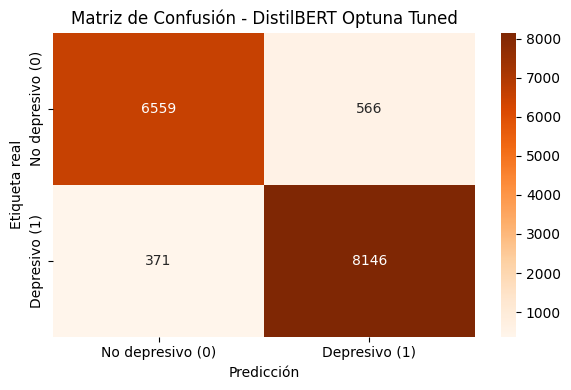

In [104]:
preds = trainer_opt.predict(test_ds)
y_pred = preds.predictions.argmax(-1)
y_true = preds.label_ids

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Oranges",
    xticklabels=["No depresivo (0)", "Depresivo (1)"],
    yticklabels=["No depresivo (0)", "Depresivo (1)"]
)

plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión - DistilBERT Optuna Tuned")
plt.tight_layout()
plt.show()

In [105]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model_optuna = DistilBertForSequenceClassification.from_pretrained(
    "./distilbert_optuna_best/checkpoint-7822"
).to("cuda")
model_optuna.eval()

def predict_proba(texts):
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()
    
    # El resto sigue igual
    tokens = tokenizer(
        texts, 
        truncation=True, 
        padding=True, 
        max_length=128, 
        return_tensors="pt"
    ).to("cuda")
    
    with torch.no_grad():
        outputs = model_optuna(**tokens)
        probs = outputs.logits.softmax(dim=1)
        
    return probs.cpu().numpy()

explainer_optuna = shap.Explainer(
    predict_proba,
    tokenizer,
    output_names=["no_depressivo", "depressivo"]
)

sample_texts = X_test_bert.sample(400, random_state=42).tolist()

shap_values_optuna = explainer_optuna(sample_texts)

PartitionExplainer explainer:  43%|████▎     | 172/400 [01:00<01:30,  2.52it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors
PartitionExplainer explainer: 401it [02:26,  2.53it/s]                         


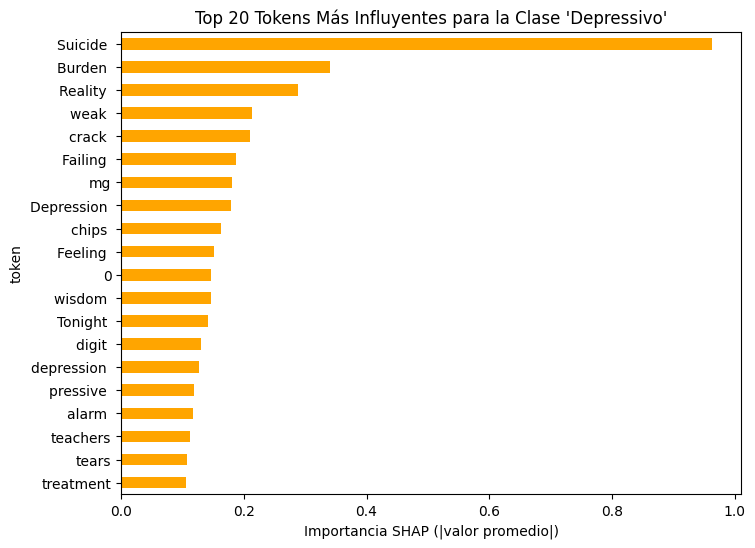

In [106]:
records_optuna = []
for ex in shap_values_optuna:
    tokens = ex.data
    values = ex.values  # lista: [value_class0, value_class1]

    for tok, val in zip(tokens, values):
        records_optuna.append({
            "token": tok,
            "value_depressivo": val[1]
        })

df_optuna = pd.DataFrame(records_optuna)
df_optuna = df_optuna[df_optuna["token"].str.strip() != ""]

global_importance_optuna = (
    df_optuna.groupby("token")["value_depressivo"]
      .apply(lambda x: np.mean(np.abs(x)))
      .sort_values(ascending=False)
)

top_n = 20
plt.figure(figsize=(8, 6))
global_importance_optuna.head(top_n).plot(kind="barh", color="orange")
plt.title("Top 20 Tokens Más Influyentes para la Clase 'Depressivo'")
plt.gca().invert_yaxis()
plt.xlabel("Importancia SHAP (|valor promedio|)")
plt.show()

# EXPORTACIÓN DE MODELOS

## Regresión Logística con TF-IDF Fine Tuned

In [107]:
import pickle
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)
    
with open("logistic_regression_model.pkl", "wb") as f:
    pickle.dump(best_lr, f)
    
print("Modelos guardados correctamente.")

Modelos guardados correctamente.


In [108]:
best_ckpt = "./distilbert_optuna_best/checkpoint-7822"
model_optuna = DistilBertForSequenceClassification.from_pretrained(best_ckpt)
tokenizer = DistilBertTokenizerFast.from_pretrained(best_ckpt)

model_optuna.save_pretrained("bert_finetuned_optuna")
tokenizer.save_pretrained("bert_finetuned_optuna")

('bert_finetuned_optuna\\tokenizer_config.json',
 'bert_finetuned_optuna\\special_tokens_map.json',
 'bert_finetuned_optuna\\vocab.txt',
 'bert_finetuned_optuna\\added_tokens.json',
 'bert_finetuned_optuna\\tokenizer.json')

# VALIDACIÓN DE MODELOS

In [110]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
nltk.download('punkt_tab')  
nltk.download('stopwords', quiet=True)
def normalize_text_advanced(text):
    """
    Función para normalización avanzada con stopwords y stemming
    """
    if pd.isna(text) or text == '':
        return ''
    
    try:
        # Convertir a string y minúsculas
        text = str(text).lower()
        
        # Remover caracteres especiales y números
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Tokenizar
        tokens = word_tokenize(text)
        
        # Remover stopwords en inglés
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
        
        # Aplicar stemming
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(word) for word in tokens]
        
        # Unir tokens
        text = ' '.join(tokens)
        
        return text
    except Exception as e:
        # Si hay error, retornar texto básico limpio
        text = str(text).lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [111]:
bert_model = DistilBertForSequenceClassification.from_pretrained("models/bert_finetuned_optuna").to("cuda")
bert_model.eval()
tokenizer = DistilBertTokenizerFast.from_pretrained("models/bert_finetuned_optuna")

def predict_bert(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to("cuda")

    with torch.no_grad():
        logits = bert_model(**inputs).logits
        probs = logits.softmax(dim=1).cpu().numpy()[0]

    pred = int(np.argmax(probs))
    return pred, probs


with open("models/LR/tfidf_vectorizer.pkl", "rb") as f:
    tfidf = pickle.load(f)

with open("models/LR/logistic_regression_model.pkl", "rb") as f:
    lr_model = pickle.load(f)


def predict_lr(text):
    clean = normalize_text_advanced(text)

    X_vec = tfidf.transform([clean])
    probs = lr_model.predict_proba(X_vec)[0]
    pred = int(np.argmax(probs))

    return pred, probs


def evaluar_texto(text):
    print(f"Texto original (Usado con BERT): \"{text}\"\n")

    clean = normalize_text_advanced(text)
    print("Texto tras normalización (Usado con LR):", clean, "\n")

    # ----- PREDICCIÓN BERT -----
    bert_pred, bert_probs = predict_bert(text)
    print("🔵 BERT Resultados:")
    print("  Probabilidades:", bert_probs)
    print("  Predicción:", "Depresivo" if bert_pred == 1 else "No depresivo", "\n")

    # ----- PREDICCIÓN LR -----
    lr_pred, lr_probs = predict_lr(text)
    print("🟣 TF-IDF + Logistic Regression Resultados:")
    print("  Probabilidades:", lr_probs)
    print("  Predicción:", "Depresivo" if lr_pred == 1 else "No depresivo", "\n")

    # ----- Comparación final -----
    print("====================================")
    if bert_pred == lr_pred:
        print("✔️ Ambos modelos coinciden →", "Depresivo" if bert_pred == 1 else "No depresivo")
    else:
        print("⚠️ Modelos NO coinciden.")
        print(f"   → BERT predice: {'Depresivo' if bert_pred == 1 else 'No depresivo'}")
        print(f"   → LR predice:   {'Depresivo' if lr_pred == 1 else 'No depresivo'}")
    print("====================================\n")

In [112]:
texto = "My life has been a rollercoaster of emotions lately, and I often find myself feeling overwhelmed and hopeless."
evaluar_texto(texto)

Texto original (Usado con BERT): "My life has been a rollercoaster of emotions lately, and I often find myself feeling overwhelmed and hopeless."

Texto tras normalización (Usado con LR): life rollercoast emot late often find feel overwhelm hopeless 

🔵 BERT Resultados:
  Probabilidades: [0.02568611 0.9743139 ]
  Predicción: Depresivo 

🟣 TF-IDF + Logistic Regression Resultados:
  Probabilidades: [0.1167741 0.8832259]
  Predicción: Depresivo 

✔️ Ambos modelos coinciden → Depresivo

